In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

plt.rcParams['text.usetex'] = True

In [2]:
def confidence_ellipse(end_x, end_y, cov, ax, n_std = 1.0, edgecolor = 'red', **kwargs):
    pearson = cov[0,1]/np.sqrt(cov[0,0] * cov[1,1])
    ell_radius_x = np.sqrt( 1 + pearson )
    ell_radius_y = np.sqrt( 1 - pearson )

    ellipse  = Ellipse((0,0), width = ell_radius_x * 2, height = ell_radius_y * 2, edgecolor = edgecolor, **kwargs)

    scale_x = np.sqrt(cov[0,0])*n_std
    scale_y = np.sqrt(cov[1,1])*n_std

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(end_x, end_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
torch.tensor(0.001)*200

tensor(0.2000)

In [4]:
kappa = torch.tensor(5., dtype=torch.double)
gamma = torch.tensor(1., dtype=torch.double)
tau = torch.tensor(1., dtype=torch.double)
delta_t = torch.tensor(0.001, dtype=torch.double)
kbT = torch.tensor(1., dtype=torch.double)
D = kbT/gamma

omega_0 = torch.sqrt(kappa)

omegasquared = kappa - gamma**2/4
omega = torch.sqrt(kappa - gamma**2/4)

zeta = torch.tensor(1./(2 * omega_0 * tau))

SigmaXt = torch.tensor([[1.,0.],[0.,1/(4*zeta**2)]])


if omegasquared>0:

    futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
        [
            [
                torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
                - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
            ],
            [
                torch.sin(omega * delta_t)/(4*zeta**2 * omega),
                torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
            ]
        ]
    )

    
                                                                 
Sigma_Xtdt_giv_Xt = SigmaXt - futurecorrelation_matrix.t()@SigmaXt.inverse()@futurecorrelation_matrix
M = torch.tensor([[0,-1],[kappa, gamma]])

/var/folders/t5/hglcpfcd3px36gr5wgd_4mtm0000gn/T/ipykernel_62777/3762745066.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(1./(2 * omega_0 * tau))


In [5]:
coordinates = torch.zeros([2,1000000], dtype=torch.double)
for t in tqdm(range(1,1000000)):
    coordinates[:,t] = torch.distributions.MultivariateNormal(
        torch.matmul(torch.matrix_exp(-M * delta_t), coordinates[:,t-1]), 
        Sigma_Xtdt_giv_Xt 
    ).sample()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999999/999999 [01:55<00:00, 8632.24it/s]


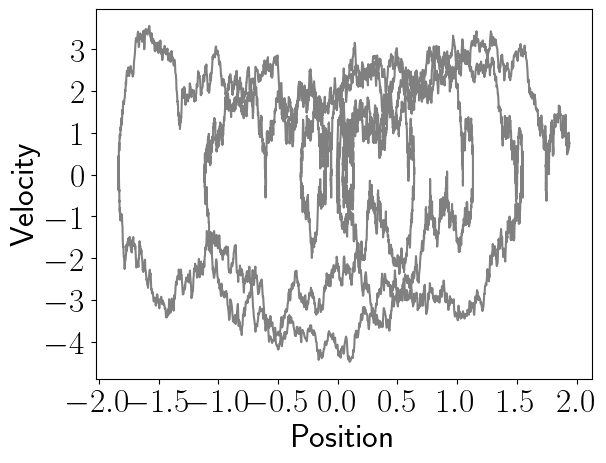

In [6]:
plt.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=1, color='grey')
plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.savefig('trajectory.pdf', bbox_inches='tight')

In [7]:
betas = np.arange(1.1,20,0.1)
end_post = []
end_obs = []
for index, beta in tqdm(enumerate(betas)):
    A = torch.eye(2, requires_grad = True, dtype=torch.double)
    K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
    SigmaXt_prior = SigmaXt.clone()
    
    
    
    
    step_size = 0.001
    max_epochs = 10000
    delta_t = torch.tensor(0.2)
    
    posterior_info = torch.zeros(max_epochs)
    obs_info = torch.zeros(max_epochs)
    losses = torch.zeros(max_epochs)
    
    futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
        [
            
            [
                torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
                - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
            ],
            [
                torch.sin(omega * delta_t)/(4*zeta**2 * omega),
                torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
            ]
        ]
    )
    
    Sigma_Xtdt_giv_Xt = SigmaXt - futurecorrelation_matrix.t()@SigmaXt.inverse()@futurecorrelation_matrix
    
    delta_L = 10
    previous_L = 0
    epoch = 0
    H = torch.matrix_exp(- M * delta_t)
    while abs(delta_L)>0.00001 and epoch<max_epochs:
        if epoch%500==0:
            SigmaXt_prior = SigmaXt.clone()

        first_term = torch.eye(2) - torch.matmul(K, A)
        second_term = torch.matmul(K, K.t()) 
        first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())
    
        SigmaXt_posterior = first_term + second_term
    
        Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
        L =  torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
        delta_L = L - previous_L
        previous_L = L
        SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt
    
    
        posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
        obs_info[epoch] = torch.log(torch.det(Sigma_obs))
        
        L.backward(retain_graph=True)
    
        K.data -= step_size * K.grad.data
    
        
        A.data -= step_size * A.grad.data
    
        K.grad.zero_()
        A.grad.zero_()
    
        losses[epoch] = L.item()
        epoch+=1

    end_post.append(posterior_info[epoch-1])
    end_obs.append(obs_info[epoch-1])

189it [20:58,  6.66s/it]


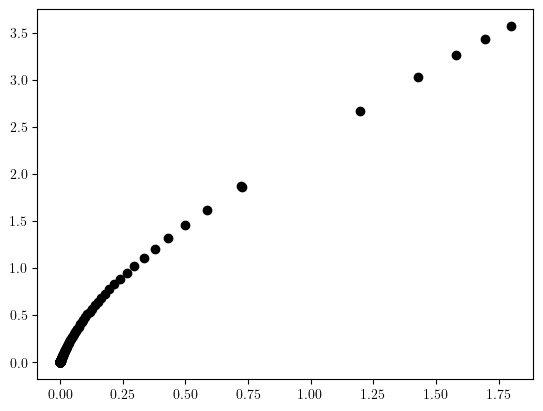

In [8]:
plt.scatter([1/2*info.detach().numpy() for info in end_obs], [1/2 * torch.log(torch.det(SigmaXt))+1/2*info.detach().numpy() for info in end_post], color = 'black')
#plt.plot([0,5],[0,5])
#plt.colorbar()
#plt.xlim((0,1.5))
#plt.ylim((0,4))
plt.savefig('info_plane.pdf', bbox_inches='tight')

In [9]:
beta = 1.25
A = torch.eye(2, requires_grad = True, dtype=torch.double)
K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
SigmaXt_prior = SigmaXt.clone()




step_size = 0.001
max_epochs = 100000
delta_t = torch.tensor(0.2, dtype=torch.double)

posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
alternative_losses = torch.zeros(max_epochs)

futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
    [
        
        [
            torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
            - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
        ],
        [
            torch.sin(omega * delta_t)/(4*zeta**2 * omega),
            torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
        ]
    ]
)

Sigma_Xtdt_giv_Xt = SigmaXt - torch.matmul(futurecorrelation_matrix.t(), torch.matmul(SigmaXt.inverse(),futurecorrelation_matrix))

delta_L = 10
previous_L = 0
epoch = 0
H = torch.matrix_exp(- M *delta_t)
for epoch in tqdm(range(max_epochs)):
    if abs(delta_L)<0.0001:
        break

    if epoch%500==0:
        #print(delta_L)
        #print(losses[epoch-1])
        SigmaXt_prior = SigmaXt.clone()

    first_term = torch.eye(2) - torch.matmul(K, A)
    second_term = torch.matmul(K, K.t()) 
    first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())

    SigmaXt_posterior = first_term + second_term

    Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
    L = torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
    delta_L = L.clone() - previous_L
    previous_L = L.clone()
    SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt


    posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
    obs_info[epoch] = torch.log(torch.det(Sigma_obs))

    L.backward(retain_graph = True)

    
    K.data -= step_size * K.grad.data

    A.data -= step_size * A.grad.data


    K.grad.zero_()
    A.grad.zero_() 

    alternative_losses[epoch] = L.clone().item()
 


  3%|████▍                                                                                                                                                               | 2687/100000 [00:16<10:07, 160.30it/s]


In [11]:
sigmaXt_giv_Zt = SigmaXt - torch.matmul(torch.matmul(torch.matmul(SigmaXt, A.t()), Sigma_obs.inverse()), torch.matmul(A, SigmaXt))

Text(0.5, 1.0, 'Optimal Encoding')

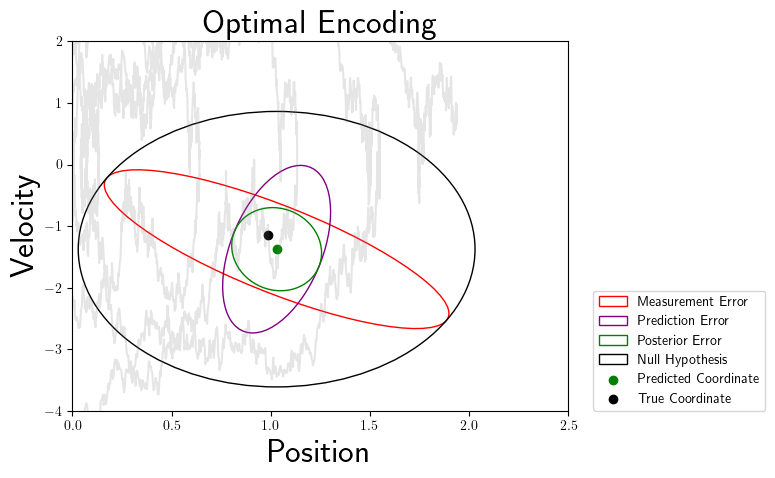

In [108]:
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
Xt_posterior = H@coordinates[:,start] + K@(A@coordinates[:,end]+obs_noise.sample() - A@H@coordinates[:,start])

confidence_ellipse(Xt_posterior[0], Xt_posterior[1], sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 1, edgecolor='blue', facecolor='None', )
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(coordinates[0,start], coordinates[1,start], color='cyan', label = 'Past Coordinate')
#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(Xt_posterior.detach().numpy()[0], Xt_posterior.detach().numpy()[1], color='green', label = 'Predicted Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))
plt.xlim((0,2.5))
plt.ylim((-4,2))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('Optimal Encoding', fontsize=24)

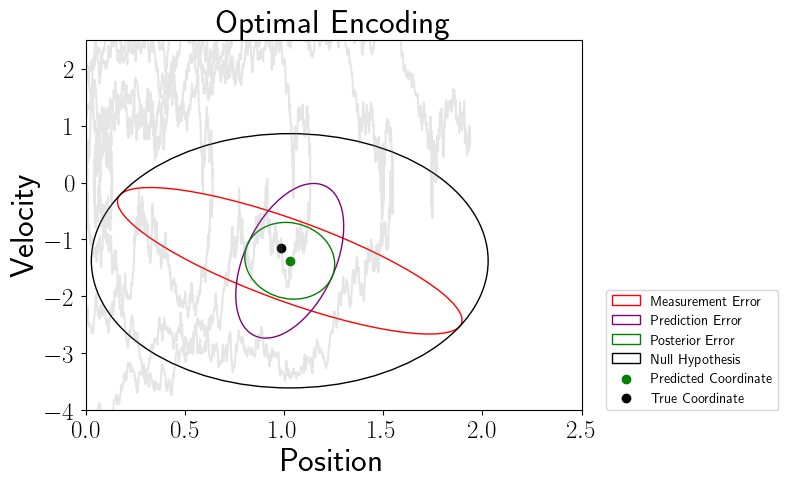

In [109]:
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

confidence_ellipse(Xt_posterior[0], Xt_posterior[1], sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 1, edgecolor='blue', facecolor='None', )
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(coordinates[0,start], coordinates[1,start], color='cyan', label = 'Past Coordinate')
#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(Xt_posterior.detach().numpy()[0], Xt_posterior.detach().numpy()[1], color='green', label = 'Predicted Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))
plt.xlim((0,2.5))
plt.ylim((-4,2.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('Optimal Encoding', fontsize=24)
plt.savefig('optimal_encoding_try_2.pdf', bbox_inches='tight')

In [20]:
R=torch.tensor([[np.cos(np.pi/2), -np.sin(np.pi/2)],[ np.sin(np.pi/2), np.cos(np.pi/2)]], dtype=torch.double)

sigmaXt_giv_Zt_standardized = sigmaXt_giv_Zt.clone()
sigmaXt_giv_Zt_standardized[0,0] = sigmaXt_giv_Zt_standardized[0,0]/SigmaXt[0][0]
sigmaXt_giv_Zt_standardized[1,0] = sigmaXt_giv_Zt_standardized[1,0]/torch.sqrt(SigmaXt[0][0] * SigmaXt[1][1])
sigmaXt_giv_Zt_standardized[0,1] = sigmaXt_giv_Zt_standardized[0,1]/torch.sqrt(SigmaXt[0][0] * SigmaXt[1][1])
sigmaXt_giv_Zt_standardized[1,1] = sigmaXt_giv_Zt_standardized[1,1]/SigmaXt[1][1]

rotated_sigmaXt_giv_Zt_standardized = torch.matmul(R, torch.matmul(sigmaXt_giv_Zt_standardized, R.t()))

rotated_sigmaXt_giv_Zt = rotated_sigmaXt_giv_Zt_standardized.clone()
rotated_sigmaXt_giv_Zt[0,0] = rotated_sigmaXt_giv_Zt[0,0] * SigmaXt[0,0]
rotated_sigmaXt_giv_Zt[1,0] = rotated_sigmaXt_giv_Zt[1,0] * torch.sqrt(SigmaXt[0,0] * SigmaXt[1,1])
rotated_sigmaXt_giv_Zt[0,1] = rotated_sigmaXt_giv_Zt[0,1] * torch.sqrt(SigmaXt[0,0] * SigmaXt[1,1])
rotated_sigmaXt_giv_Zt[1,1] = rotated_sigmaXt_giv_Zt[1,1] * SigmaXt[1,1]

print(rotated_sigmaXt_giv_Zt)
perturbed_A = torch.linalg.cholesky(((SigmaXt.inverse() - torch.matmul(SigmaXt.inverse(), torch.matmul(rotated_sigmaXt_giv_Zt, SigmaXt.inverse()))).inverse() - SigmaXt).inverse()).t()

print(perturbed_A)
perturbed_Sigma_obs = torch.matmul(perturbed_A, torch.matmul(SigmaXt, perturbed_A.t())) + torch.eye(2)


tensor([[0.3321, 0.9058],
        [0.9058, 3.7714]], dtype=torch.float64, grad_fn=<CopySlices>)
tensor([[ 2.7803e+00, -7.5417e-01],
        [ 0.0000e+00,  5.8455e-04]], dtype=torch.float64, grad_fn=<TBackward0>)


In [21]:
perturbed_Sigma_obs = torch.matmul(perturbed_A, torch.matmul(SigmaXt, perturbed_A.t())) + torch.eye(2)
rotated_sigmaXt_giv_Zt = SigmaXt - SigmaXt@perturbed_A.t()@perturbed_Sigma_obs.inverse()@perturbed_A@SigmaXt

In [22]:
rotated_sigmaXt_giv_Zt

tensor([[0.3321, 0.9058],
        [0.9058, 3.7714]], dtype=torch.float64, grad_fn=<SubBackward0>)

In [23]:

perturbed_SigmaXt_prior = SigmaXt.clone()
perturbed_K = torch.zeros((2,2), dtype=torch.double)
for r in range(10000):
    if r%100==0:
        print(perturbed_K)
    perturbed_K = perturbed_SigmaXt_prior@perturbed_A.t()@((perturbed_A@perturbed_SigmaXt_prior@perturbed_A.t() + torch.eye(2)).inverse())
    perturbed_SigmaXt_posterior = (torch.eye(2) - perturbed_K@perturbed_A)@perturbed_SigmaXt_prior@((torch.eye(2) - perturbed_K@perturbed_A).t()) + perturbed_K@perturbed_K.t()
    perturbed_SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(perturbed_SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt
    
perturbed_SigmaXt_posterior = (torch.eye(2) - perturbed_K@perturbed_A)@perturbed_SigmaXt_prior


tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
     

In [24]:
perturbed_K

tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)

tensor([1.1020, 0.0228], dtype=torch.float64, grad_fn=<AddBackward0>)


(-4.0, 2.5)

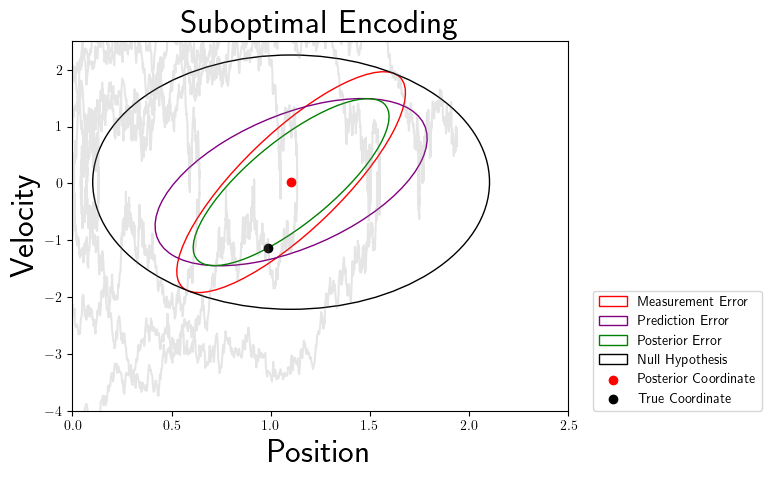

In [33]:
perturbed_Sigma_obs = torch.matmul(perturbed_A, torch.matmul(SigmaXt, perturbed_A.t())) + torch.eye(2)
rotated_sigmaXt_giv_Zt = SigmaXt - SigmaXt@perturbed_A.t()@perturbed_Sigma_obs.inverse()@perturbed_A@SigmaXt
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
perturbed_Xt_posterior = H@coordinates[:,start] + perturbed_K@(
    perturbed_A@coordinates[:,end] + obs_noise.sample() - perturbed_A@H@coordinates[:,start]
)
print(perturbed_Xt_posterior)

confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], rotated_sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(perturbed_Xt_posterior.detach().numpy()[0], perturbed_Xt_posterior.detach().numpy()[1], color='red', label = 'Posterior Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))



plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('Suboptimal Encoding', fontsize=24)
plt.xlim((0,2.5))
plt.ylim((-4,2.5))

#plt.savefig('suboptimal.pdf', bbox_inches='tight')

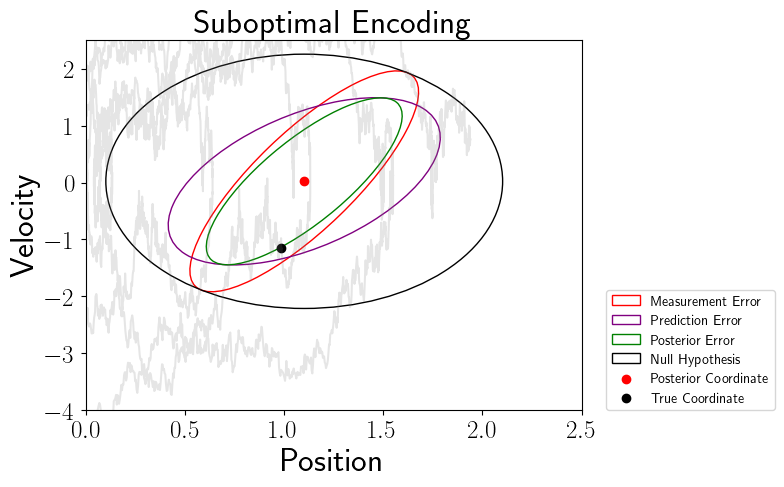

In [35]:
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')


confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], rotated_sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(perturbed_Xt_posterior.detach().numpy()[0], perturbed_Xt_posterior.detach().numpy()[1], color='red', label = 'Posterior Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))
plt.xlim((0,2.5))
plt.ylim((-4,2.5))


plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title('Suboptimal Encoding', fontsize=24)
plt.savefig('suboptimal_try_2.pdf', bbox_inches='tight')

In [38]:
high_A = 20*torch.eye(2, dtype=torch.double)
high_SigmaXt_prior = SigmaXt.clone()
high_K = torch.zeros((2,2), dtype=torch.double)
for r in range(10000):
    if r%100==0:
        print(perturbed_K)
    high_K = high_SigmaXt_prior@high_A.t()@((high_A@high_SigmaXt_prior@high_A.t() + torch.eye(2)).inverse())
    high_SigmaXt_posterior = (torch.eye(2) - high_K@high_A)@high_SigmaXt_prior@((torch.eye(2) - high_K@high_A).t()) + high_K@high_K.t()
    high_SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(high_SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt
    
high_SigmaXt_posterior = (torch.eye(2) - high_K@high_A)@high_SigmaXt_prior


tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.2489,  0.0003],
        [-0.0453,  0.0013]], dtype=torch.float64, grad_fn=<MmBa

tensor([ 1.0080, -1.1484], dtype=torch.float64)


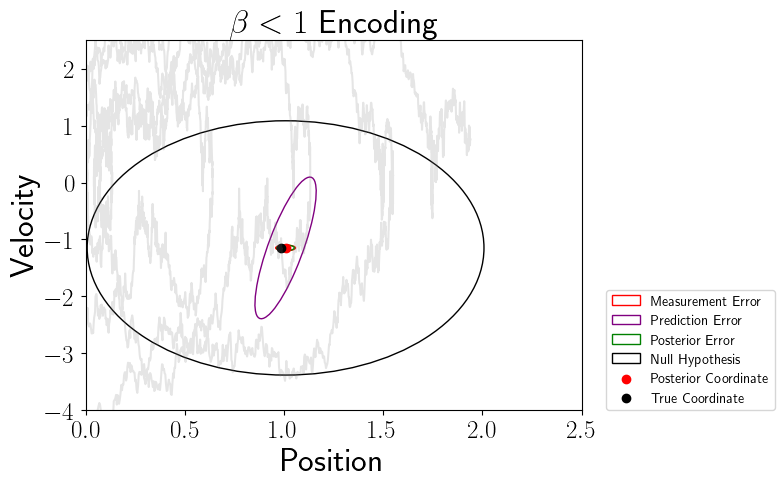

In [48]:
high_Sigma_obs = torch.matmul(high_A, torch.matmul(SigmaXt, high_A.t())) + torch.eye(2)
high_sigmaXt_giv_Zt = SigmaXt - SigmaXt@high_A.t()@high_Sigma_obs.inverse()@high_A@SigmaXt
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
high_Xt_posterior = H@coordinates[:,start] + high_K@(
    high_A@coordinates[:,end] + obs_noise.sample() - high_A@H@coordinates[:,start]
)
print(high_Xt_posterior)

confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], high_sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 1, edgecolor='blue', facecolor='None', )
confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], high_SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], high_SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(high_Xt_posterior.detach().numpy()[0], high_Xt_posterior.detach().numpy()[1], color='red', label = 'Posterior Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))



plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title('$\\beta<1$ Encoding', fontsize=24)
plt.xlim((0,2.5))
plt.ylim((-4,2.5))
plt.savefig('low_beta_encoding.pdf', bbox_inches='tight')

tensor([ 1.0080, -1.1484], dtype=torch.float64)


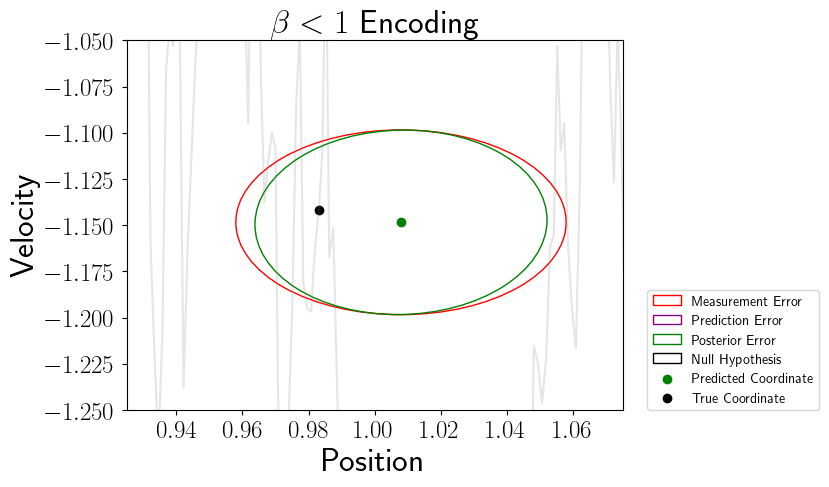

In [111]:
high_Sigma_obs = torch.matmul(high_A, torch.matmul(SigmaXt, high_A.t())) + torch.eye(2)
high_sigmaXt_giv_Zt = SigmaXt - SigmaXt@high_A.t()@high_Sigma_obs.inverse()@high_A@SigmaXt
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
#high_Xt_posterior = H@coordinates[:,start] + high_K@(
#    high_A@coordinates[:,end] + obs_noise.sample() - high_A@H@coordinates[:,start]
#)
print(high_Xt_posterior)

confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], high_sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], high_SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], high_SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(high_Xt_posterior[0], high_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(high_Xt_posterior.detach().numpy()[0], high_Xt_posterior.detach().numpy()[1], color='green', label = 'Predicted Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))



plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('$\\beta<1$ Encoding', fontsize=24, usetex=True)
plt.xlim((0.925,1.075))
plt.ylim((-1.25,-1.05))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('low_beta_encoding_tight.pdf', bbox_inches='tight')

In [53]:
beta = 1.1
A = torch.eye(2, requires_grad = True, dtype=torch.double)
K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
SigmaXt_prior = SigmaXt.clone()




step_size = 0.001
max_epochs = 100000
delta_t = torch.tensor(0.2, dtype=torch.double)

posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
alternative_losses = torch.zeros(max_epochs)

futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
    [
        
        [
            torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
            - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
        ],
        [
            torch.sin(omega * delta_t)/(4*zeta**2 * omega),
            torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
        ]
    ]
)

Sigma_Xtdt_giv_Xt = SigmaXt - torch.matmul(futurecorrelation_matrix.t(), torch.matmul(SigmaXt.inverse(),futurecorrelation_matrix))

delta_L = 10
previous_L = 0
epoch = 0
H = torch.matrix_exp(- M *delta_t)
for epoch in tqdm(range(max_epochs)):
    if abs(delta_L)<0.0001:
        break

    if epoch%500==0:
        #print(delta_L)
        #print(losses[epoch-1])
        SigmaXt_prior = SigmaXt.clone()

    first_term = torch.eye(2) - torch.matmul(K, A)
    second_term = torch.matmul(K, K.t()) 
    first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())

    SigmaXt_posterior = first_term + second_term

    Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
    L = torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
    delta_L = L.clone() - previous_L
    previous_L = L.clone()
    SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt


    posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
    obs_info[epoch] = torch.log(torch.det(Sigma_obs))

    L.backward(retain_graph = True)

    
    K.data -= step_size * K.grad.data

    A.data -= step_size * A.grad.data


    K.grad.zero_()
    A.grad.zero_() 

    alternative_losses[epoch] = L.clone().item()
 


  3%|█████▋                                                                                                                                                              | 3497/100000 [00:22<10:15, 156.74it/s]


Text(0.5, 1.0, 'Low Cost Encoding')

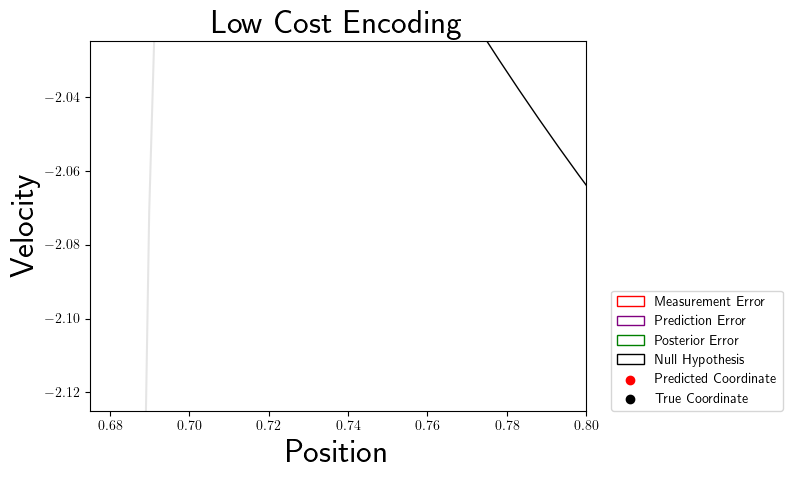

In [54]:
sigmaXt_giv_Zt_3 = SigmaXt - torch.matmul(torch.matmul(torch.matmul(SigmaXt, A.t()), Sigma_obs.inverse()), torch.matmul(A, SigmaXt))

fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
Xt_posterior = H@coordinates[:,start] + K@(A@coordinates[:,end]+obs_noise.sample() - A@H@coordinates[:,start])

confidence_ellipse(Xt_posterior[0], Xt_posterior[1], sigmaXt_giv_Zt.detach().numpy(), axs, 0.5, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_prior.detach().numpy(), axs, 0.5, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_posterior.detach().numpy(), axs, 0.5, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt, axs, 0.5, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(coordinates[0,start], coordinates[1,start], color='cyan', label = 'Past Coordinate')
#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(Xt_posterior.detach().numpy()[0], Xt_posterior.detach().numpy()[1], color='red', label = 'Predicted Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))
plt.xlim((0.675,0.8))
plt.ylim((-2.125,-2.025))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('Low Cost Encoding', fontsize=24)

In [55]:
beta = 1.5
A = torch.eye(2, requires_grad = True, dtype=torch.double)
K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
SigmaXt_prior = SigmaXt.clone()




step_size = 0.001
max_epochs = 100000
delta_t = torch.tensor(0.2, dtype=torch.double)

posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
alternative_losses = torch.zeros(max_epochs)

futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
    [
        
        [
            torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
            - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
        ],
        [
            torch.sin(omega * delta_t)/(4*zeta**2 * omega),
            torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
        ]
    ]
)

Sigma_Xtdt_giv_Xt = SigmaXt - torch.matmul(futurecorrelation_matrix.t(), torch.matmul(SigmaXt.inverse(),futurecorrelation_matrix))

delta_L = 10
previous_L = 0
epoch = 0
H = torch.matrix_exp(- M *delta_t)
for epoch in tqdm(range(max_epochs)):
    if abs(delta_L)<0.0001:
        break

    if epoch%500==0:
        #print(delta_L)
        #print(losses[epoch-1])
        SigmaXt_prior = SigmaXt.clone()

    first_term = torch.eye(2) - torch.matmul(K, A)
    second_term = torch.matmul(K, K.t()) 
    first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())

    SigmaXt_posterior = first_term + second_term

    Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
    L = torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
    delta_L = L.clone() - previous_L
    previous_L = L.clone()
    SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt


    posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
    obs_info[epoch] = torch.log(torch.det(Sigma_obs))

    L.backward(retain_graph = True)

    
    K.data -= step_size * K.grad.data

    A.data -= step_size * A.grad.data


    K.grad.zero_()
    A.grad.zero_() 

    alternative_losses[epoch] = L.clone().item()
 


  1%|██▍                                                                                                                                                                 | 1470/100000 [00:09<10:14, 160.46it/s]


Text(0.5, 1.0, 'Low Cost Encoding')

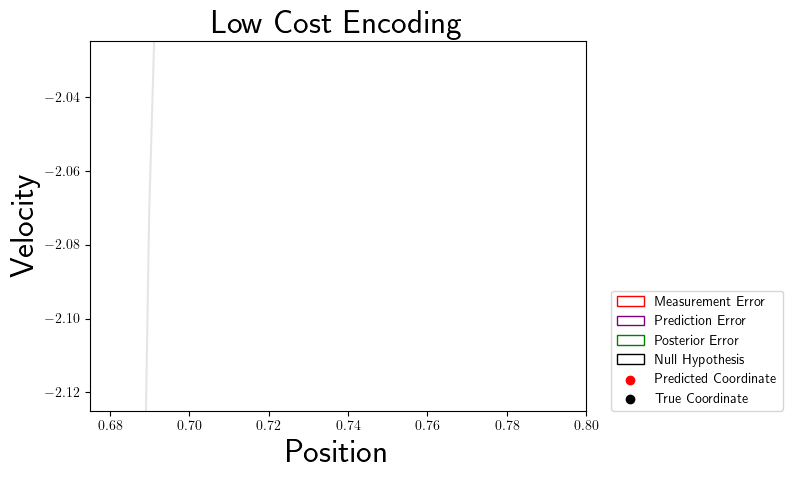

In [56]:
sigmaXt_giv_Zt_4 = SigmaXt - torch.matmul(torch.matmul(torch.matmul(SigmaXt, A.t()), Sigma_obs.inverse()), torch.matmul(A, SigmaXt))

fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
Xt_posterior = H@coordinates[:,start] + K@(A@coordinates[:,end]+obs_noise.sample() - A@H@coordinates[:,start])

confidence_ellipse(Xt_posterior[0], Xt_posterior[1], sigmaXt_giv_Zt.detach().numpy(), axs, 0.5, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_prior.detach().numpy(), axs, 0.5, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt_posterior.detach().numpy(), axs, 0.5, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(Xt_posterior[0], Xt_posterior[1], SigmaXt, axs, 0.5, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(coordinates[0,start], coordinates[1,start], color='cyan', label = 'Past Coordinate')
#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(Xt_posterior.detach().numpy()[0], Xt_posterior.detach().numpy()[1], color='red', label = 'Predicted Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))
plt.xlim((0.675,0.8))
plt.ylim((-2.125,-2.025))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('Low Cost Encoding', fontsize=24)

In [57]:
beta = 2
A = torch.eye(2, requires_grad = True, dtype=torch.double)
K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
SigmaXt_prior = SigmaXt.clone()




step_size = 0.001
max_epochs = 100000
delta_t = torch.tensor(0.2, dtype=torch.double)

posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
alternative_losses = torch.zeros(max_epochs)

futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
    [
        
        [
            torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
            - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
        ],
        [
            torch.sin(omega * delta_t)/(4*zeta**2 * omega),
            torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
        ]
    ]
)

Sigma_Xtdt_giv_Xt = SigmaXt - torch.matmul(futurecorrelation_matrix.t(), torch.matmul(SigmaXt.inverse(),futurecorrelation_matrix))

delta_L = 10
previous_L = 0
epoch = 0
H = torch.matrix_exp(- M *delta_t)
for epoch in tqdm(range(max_epochs)):
    if abs(delta_L)<0.0001:
        break

    if epoch%500==0:
        #print(delta_L)
        #print(losses[epoch-1])
        SigmaXt_prior = SigmaXt.clone()

    first_term = torch.eye(2) - torch.matmul(K, A)
    second_term = torch.matmul(K, K.t()) 
    first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())

    SigmaXt_posterior = first_term + second_term

    Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
    L = torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
    delta_L = L.clone() - previous_L
    previous_L = L.clone()
    SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt


    posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
    obs_info[epoch] = torch.log(torch.det(Sigma_obs))

    L.backward(retain_graph = True)

    
    K.data -= step_size * K.grad.data

    A.data -= step_size * A.grad.data


    K.grad.zero_()
    A.grad.zero_() 

    alternative_losses[epoch] = L.clone().item()
 
sigmaXt_giv_Zt_5 = SigmaXt - torch.matmul(torch.matmul(torch.matmul(SigmaXt, A.t()), Sigma_obs.inverse()), torch.matmul(A, SigmaXt))


  1%|█▍                                                                                                                                                                   | 905/100000 [00:05<09:33, 172.78it/s]


In [58]:
beta = 4
A = torch.eye(2, requires_grad = True, dtype=torch.double)
K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
SigmaXt_prior = SigmaXt.clone()




step_size = 0.001
max_epochs = 100000
delta_t = torch.tensor(0.2, dtype=torch.double)

posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
alternative_losses = torch.zeros(max_epochs)

futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
    [
        
        [
            torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
            - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
        ],
        [
            torch.sin(omega * delta_t)/(4*zeta**2 * omega),
            torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
        ]
    ]
)

Sigma_Xtdt_giv_Xt = SigmaXt - torch.matmul(futurecorrelation_matrix.t(), torch.matmul(SigmaXt.inverse(),futurecorrelation_matrix))

delta_L = 10
previous_L = 0
epoch = 0
H = torch.matrix_exp(- M *delta_t)
for epoch in tqdm(range(max_epochs)):
    if abs(delta_L)<0.0001:
        break

    if epoch%500==0:
        #print(delta_L)
        #print(losses[epoch-1])
        SigmaXt_prior = SigmaXt.clone()

    first_term = torch.eye(2) - torch.matmul(K, A)
    second_term = torch.matmul(K, K.t()) 
    first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())

    SigmaXt_posterior = first_term + second_term

    Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
    L = torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
    delta_L = L.clone() - previous_L
    previous_L = L.clone()
    SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt


    posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
    obs_info[epoch] = torch.log(torch.det(Sigma_obs))

    L.backward(retain_graph = True)

    
    K.data -= step_size * K.grad.data

    A.data -= step_size * A.grad.data


    K.grad.zero_()
    A.grad.zero_() 

    alternative_losses[epoch] = L.clone().item()
 
sigmaXt_giv_Zt_6 = SigmaXt - torch.matmul(torch.matmul(torch.matmul(SigmaXt, A.t()), Sigma_obs.inverse()), torch.matmul(A, SigmaXt))


  1%|▉                                                                                                                                                                    | 579/100000 [00:03<09:15, 179.00it/s]


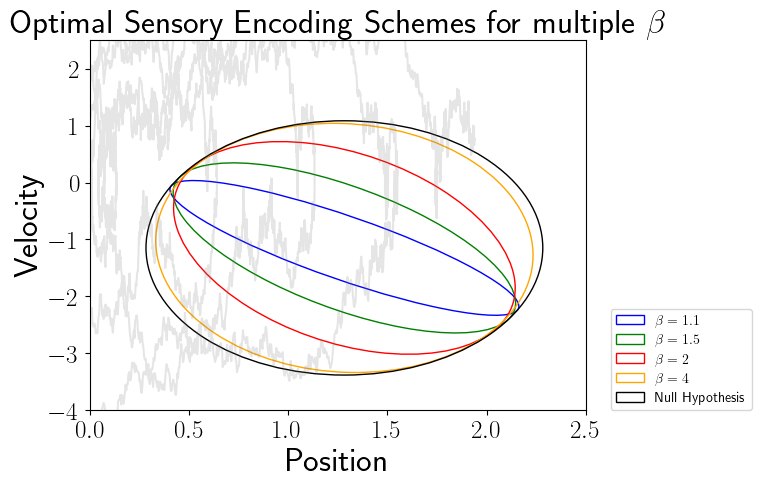

In [63]:
fig, axs = plt.subplots()

axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')
#confidence_ellipse(Xt_posterior[0], Xt_posterior[1], sigmaXt_giv_Zt_1.detach().numpy(), axs, 0.5, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(Xt_posterior[0], Xt_posterior[1], sigmaXt_giv_Zt_2.detach().numpy(), axs, 0.5, edgecolor='red', facecolor='None', label = 'Measurement Error')
confidence_ellipse(Xt_posterior[0], high_Xt_posterior[1], sigmaXt_giv_Zt_3.detach().numpy(), axs, 1, edgecolor='blue', facecolor='None', label = '$\\beta = 1.1$')
confidence_ellipse(Xt_posterior[0], high_Xt_posterior[1], sigmaXt_giv_Zt_4.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = '$\\beta = 1.5$')
confidence_ellipse(Xt_posterior[0], high_Xt_posterior[1], sigmaXt_giv_Zt_5.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = '$\\beta = 2$')
confidence_ellipse(Xt_posterior[0], high_Xt_posterior[1], sigmaXt_giv_Zt_6.detach().numpy(), axs, 1, edgecolor='orange', facecolor='None', label = '$\\beta = 4$')

confidence_ellipse(Xt_posterior[0], high_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

plt.legend(loc=(1.05,0))
plt.xlim((0,2.5))
plt.ylim((-4,2.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Optimal Sensory Encoding Schemes for multiple $\\beta$', fontsize=24)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.savefig('multiple_sensory_encoding_schemes.pdf', bbox_inches='tight')

In [ ]:
sigmaXt_giv_Zt_5 = SigmaXt - torch.matmul(torch.matmul(torch.matmul(SigmaXt, A.t()), Sigma_obs.inverse()), torch.matmul(A, SigmaXt))


In [61]:
cmap = plt.get_cmap('copper', 5)

In [ ]:
boundaries = [0,0.25, 0.5, 0.75, 1]

In [ ]:
import matplotlib.colors as colors

norm = colors.BoundaryNorm(boundaries, cmap.N)

In [ ]:
norm(np.array([0.25]))

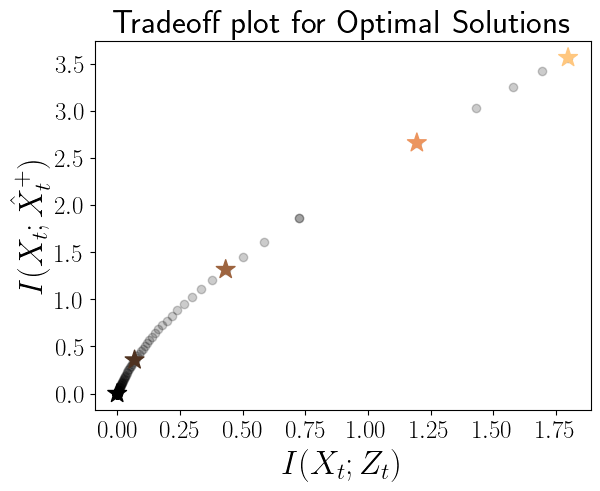

In [62]:
plt.scatter([1/2*info.detach().numpy() for info in end_obs], [1/2 * torch.log(torch.det(SigmaXt))+1/2*info.detach().numpy() for info in end_post], color = 'black', alpha=0.2)


plt.scatter(
    [
        [1/2*info.detach().numpy() for info in end_obs][0],
        [1/2*info.detach().numpy() for info in end_obs][4],
        [1/2*info.detach().numpy() for info in end_obs][9],
        [1/2*info.detach().numpy() for info in end_obs][29],
        0,
    ],
    [
        [1/2 * torch.log(torch.det(SigmaXt))+1/2*info.detach().numpy() for info in end_post][0],
        [1/2 * torch.log(torch.det(SigmaXt))+1/2*info.detach().numpy() for info in end_post][4],
        [1/2 * torch.log(torch.det(SigmaXt))+1/2*info.detach().numpy() for info in end_post][9],
        [1/2 * torch.log(torch.det(SigmaXt))+1/2*info.detach().numpy() for info in end_post][29],
        0
    ],
    c = [20,15,10,5,0],
    cmap=cmap,
    marker = '*',
    s=200
)
plt.xlabel('$I(X_{t};Z_{t})$', fontsize=24)
plt.ylabel('$I(X_{t};\hat{X}^{+}_{t})$', fontsize=24)

#plt.plot([0,5],[0,5])
#plt.colorbar()
#plt.xlim((0,1.5))
#plt.ylim((0,4))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Tradeoff plot for Optimal Solutions', fontsize=24)
plt.savefig('info_plane.pdf', bbox_inches='tight')

In [64]:
beta = 1.25
A = torch.eye(2, requires_grad = True, dtype=torch.double)
K = torch.zeros((2,2), requires_grad = True, dtype=torch.double)
SigmaXt_prior = SigmaXt.clone()




step_size = 0.001
max_epochs = 100000
delta_t = torch.tensor(0.2, dtype=torch.double)

posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
alternative_losses = torch.zeros(max_epochs)

futurecorrelation_matrix = torch.exp(-delta_t/2.) * torch.tensor(
    [
        
        [
            torch.cos(omega * delta_t) + torch.sin(omega * delta_t)/(2*omega),
            - torch.sin(omega * delta_t)/(4*zeta**2 * omega)
        ],
        [
            torch.sin(omega * delta_t)/(4*zeta**2 * omega),
            torch.cos(omega * delta_t)/(4*zeta**2) - torch.sin(omega * delta_t)/(8*omega*zeta**2)
        ]
    ]
)

Sigma_Xtdt_giv_Xt = SigmaXt - torch.matmul(futurecorrelation_matrix.t(), torch.matmul(SigmaXt.inverse(),futurecorrelation_matrix))

delta_L = 10
previous_L = 0
epoch = 0
H = torch.matrix_exp(- M *delta_t)
for epoch in tqdm(range(max_epochs)):
    if abs(delta_L)<0.0001:
        break

    if epoch%500==0:
        #print(delta_L)
        #print(losses[epoch-1])
        SigmaXt_prior = SigmaXt.clone()

    first_term = torch.eye(2) - torch.matmul(K, A)
    second_term = torch.matmul(K, K.t()) 
    first_term = torch.matmul(torch.matmul(first_term, SigmaXt_prior), first_term.t())

    SigmaXt_posterior = first_term + second_term

    Sigma_obs = torch.matmul(torch.matmul(A, SigmaXt), A.t()) + torch.eye(2)
    L = torch.log(torch.linalg.det(SigmaXt_posterior)) + beta * torch.log(torch.det(Sigma_obs))
    delta_L = L.clone() - previous_L
    previous_L = L.clone()
    SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt


    posterior_info[epoch] = - torch.log(torch.linalg.det(SigmaXt_posterior))
    obs_info[epoch] = torch.log(torch.det(Sigma_obs))

    L.backward(retain_graph = True)

    
    K.data -= step_size * K.grad.data

    A.data -= step_size * A.grad.data


    K.grad.zero_()
    A.grad.zero_() 

    alternative_losses[epoch] = L.clone().item()
 


  3%|████▍                                                                                                                                                               | 2687/100000 [00:17<10:49, 149.78it/s]


In [102]:
R=torch.tensor([[np.cos(np.pi/2), -np.sin(np.pi/2)],[ np.sin(np.pi/2), np.cos(np.pi/2)]], dtype=torch.double)

sigmaXt_giv_Zt_standardized = sigmaXt_giv_Zt.clone()
sigmaXt_giv_Zt_standardized[0,0] = sigmaXt_giv_Zt_standardized[0,0]/SigmaXt[0][0]
sigmaXt_giv_Zt_standardized[1,0] = sigmaXt_giv_Zt_standardized[1,0]/torch.sqrt(SigmaXt[0][0] * SigmaXt[1][1])
sigmaXt_giv_Zt_standardized[0,1] = sigmaXt_giv_Zt_standardized[0,1]/torch.sqrt(SigmaXt[0][0] * SigmaXt[1][1])
sigmaXt_giv_Zt_standardized[1,1] = sigmaXt_giv_Zt_standardized[1,1]/SigmaXt[1][1]

vals, vecs = torch.linalg.eig(sigmaXt_giv_Zt_standardized)



rotated_sigmaXt_giv_Zt_standardized = torch.real(1/2 * vals[0]) * torch.outer(torch.real(vecs[:,0]), torch.real(vecs[:,0])) + torch.real(vals[1]) * torch.outer(torch.real(vecs[:,1]), torch.real(vecs[:,1]))

rotated_sigmaXt_giv_Zt = rotated_sigmaXt_giv_Zt_standardized.clone()
rotated_sigmaXt_giv_Zt[0,0] = rotated_sigmaXt_giv_Zt[0,0] * SigmaXt[0,0]
rotated_sigmaXt_giv_Zt[1,0] = rotated_sigmaXt_giv_Zt[1,0] * torch.sqrt(SigmaXt[0,0] * SigmaXt[1,1])
rotated_sigmaXt_giv_Zt[0,1] = rotated_sigmaXt_giv_Zt[0,1] * torch.sqrt(SigmaXt[0,0] * SigmaXt[1,1])
rotated_sigmaXt_giv_Zt[1,1] = rotated_sigmaXt_giv_Zt[1,1] * SigmaXt[1,1]

print(rotated_sigmaXt_giv_Zt)
perturbed_A = torch.linalg.cholesky(((SigmaXt.inverse() - torch.matmul(SigmaXt.inverse(), torch.matmul(rotated_sigmaXt_giv_Zt, SigmaXt.inverse()))).inverse() - SigmaXt).inverse()).t()

print(perturbed_A)
perturbed_Sigma_obs = torch.matmul(perturbed_A, torch.matmul(SigmaXt, perturbed_A.t())) + torch.eye(2)


tensor([[ 0.3888, -0.4101],
        [-0.4101,  0.9882]], dtype=torch.float64, grad_fn=<CopySlices>)
tensor([[1.8907, 1.0041],
        [0.0000, 0.7691]], dtype=torch.float64, grad_fn=<TBackward0>)


In [103]:

perturbed_SigmaXt_prior = SigmaXt.clone()
perturbed_K = torch.zeros((2,2), dtype=torch.double)
for r in range(10000):
    if r%100==0:
        print(perturbed_K)
    perturbed_K = perturbed_SigmaXt_prior@perturbed_A.t()@((perturbed_A@perturbed_SigmaXt_prior@perturbed_A.t() + torch.eye(2)).inverse())
    perturbed_SigmaXt_posterior = (torch.eye(2) - perturbed_K@perturbed_A)@perturbed_SigmaXt_prior@((torch.eye(2) - perturbed_K@perturbed_A).t()) + perturbed_K@perturbed_K.t()
    perturbed_SigmaXt_prior = torch.matmul(torch.matrix_exp(- M * delta_t), torch.matmul(perturbed_SigmaXt_posterior, torch.matrix_exp(-M*delta_t).t())) + Sigma_Xtdt_giv_Xt
    
perturbed_SigmaXt_posterior = (torch.eye(2) - perturbed_K@perturbed_A)@perturbed_SigmaXt_prior


tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
        [ 0.4268,  0.3356]], dtype=torch.float64, grad_fn=<MmBackward0>)
tensor([[ 0.0841, -0.0046],
     

tensor([ 1.0423, -0.8525], dtype=torch.float64, grad_fn=<AddBackward0>)


(-4.0, 2.5)

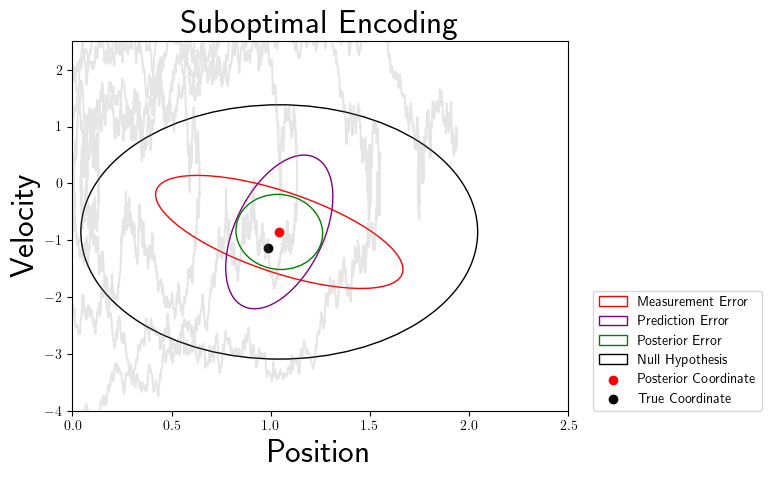

In [105]:
perturbed_Sigma_obs = torch.matmul(perturbed_A, torch.matmul(SigmaXt, perturbed_A.t())) + torch.eye(2)
rotated_sigmaXt_giv_Zt = SigmaXt - SigmaXt@perturbed_A.t()@perturbed_Sigma_obs.inverse()@perturbed_A@SigmaXt
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')

start = 1000
end = start + 200

H = torch.matrix_exp(-M * delta_t)

mean_coordinate = H@coordinates[:,start]

obs_noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
perturbed_Xt_posterior = H@coordinates[:,start] + perturbed_K@(
    perturbed_A@coordinates[:,end] + obs_noise.sample() - perturbed_A@H@coordinates[:,start]
)
print(perturbed_Xt_posterior)

confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], rotated_sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(perturbed_Xt_posterior.detach().numpy()[0], perturbed_Xt_posterior.detach().numpy()[1], color='red', label = 'Posterior Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))



plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.title('Suboptimal Encoding', fontsize=24)
plt.xlim((0,2.5))
plt.ylim((-4,2.5))

#plt.savefig('suboptimal.pdf', bbox_inches='tight')

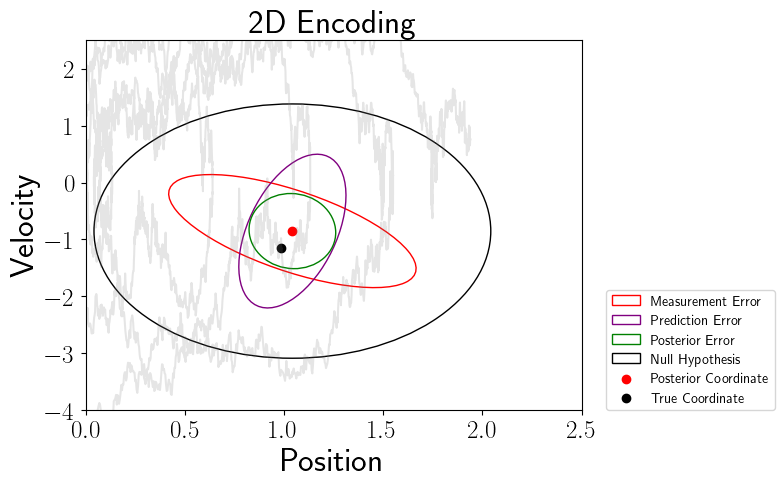

In [106]:
fig, axs = plt.subplots()
axs.plot(coordinates[0,:10000], coordinates[1,:10000], alpha=0.2, color='grey')


confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], rotated_sigmaXt_giv_Zt.detach().numpy(), axs, 1, edgecolor='red', facecolor='None', label = 'Measurement Error')
#confidence_ellipse(coordinates[0,1000], coordinates[1,1000], sigma_obs_pred.detach().numpy(), axs, 0.5, edgecolor='blue', facecolor='None', )
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_prior.detach().numpy(), axs, 1, edgecolor='purple', facecolor='None', label = 'Prediction Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], perturbed_SigmaXt_posterior.detach().numpy(), axs, 1, edgecolor='green', facecolor='None', label = 'Posterior Error')
confidence_ellipse(perturbed_Xt_posterior[0], perturbed_Xt_posterior[1], SigmaXt, axs, 1, edgecolor='black', facecolor='None', label = 'Null Hypothesis')

#axs.scatter(mean_coordinate[0], mean_coordinate[1], color='blue', label = 'Mean Coordinate')
axs.scatter(perturbed_Xt_posterior.detach().numpy()[0], perturbed_Xt_posterior.detach().numpy()[1], color='red', label = 'Posterior Coordinate')
axs.scatter(coordinates[0,end], coordinates[1,end], color='black', label = 'True Coordinate')
plt.legend(loc=(1.05,0))
plt.xlim((0,2.5))
plt.ylim((-4,2.5))


plt.xlabel('Position', fontsize=24)
plt.ylabel('Velocity', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title('2D Encoding', fontsize=24)
plt.savefig('2_d_encoding.pdf', bbox_inches='tight')